In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_lmm, reg_nn_embed, reg_nn_rnn
from lmmnn.simulation import Count

import tensorflow.keras.backend as K

from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns

In [2]:
def cartesian(arrays, out=None):
    """
    Source: https://stackoverflow.com/a/1235363
    Generate a Cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the Cartesian product of.
    out : ndarray
        Array to place the Cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing Cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

[[1 1]
 [0 0]
 [1 0]
 [0 1]]
500
(2000, 2) (2000, 2)
SEED:  838


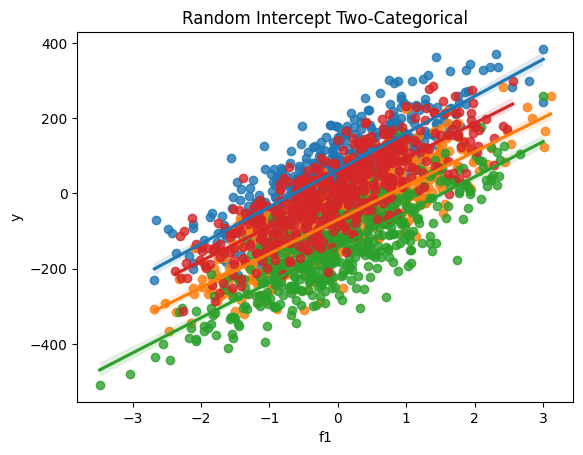

<Figure size 640x480 with 0 Axes>

In [3]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import random

# SEED = np.random.randint(1000)
SEED = 838
np.random.seed(SEED)
random.seed(SEED)

no_meaningful_groups = 2
n_features = 2

meaningful_groups = {f"g{i}": [0,1] for i in range(1,no_meaningful_groups+1)}

n_samples_per_group = 500
combinations = cartesian([v for v in meaningful_groups.values()])
np.random.shuffle(combinations)
print(combinations)
print(n_samples_per_group)
X, y, coeff = make_regression(n_samples=n_samples_per_group * len(combinations), n_features=n_features, noise=2, coef=True)

start = 0
for c in combinations:
    y[start:(start+n_samples_per_group)] += np.random.normal(0,50)#np.random.randint(-100,100)
#     y[start:(start+n_samples_per_group)] = y[start:(start+n_samples_per_group)]*np.random.random()
    sns.regplot(x=X[start:(start+n_samples_per_group),0], y=y[start:(start+n_samples_per_group)])
    start += n_samples_per_group

X_features = X
X_groups = np.repeat(combinations, n_samples_per_group, axis=0)
print(X.shape, X_groups.shape)

X = np.concatenate([X_features, X_groups], axis=1)
plt.xlabel("f1")
plt.ylabel("y")
plt.title("Random Intercept Two-Categorical")
plt.figure()
print("SEED: ", SEED)

In [4]:
df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)] + list(meaningful_groups.keys()))

for i in range(3,11):
    df[f"g{i}"] = np.random.randint(0, 2, size=len(df))

df["y"] = y
df.head()

c = df.filter(regex="g").columns
df[c] = df[c].astype(int)
# df = df.sample(frac=1, random_state=100)
# df.reset_index(drop=True, inplace=True)
df.head()


,f0,f1,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,y
0,-0.890556,-0.773309,1,1,1,1,0,0,1,1,0,1,-69.449261
1,-1.062653,-1.416183,1,1,1,1,0,1,1,0,1,0,-127.441666
2,1.082458,-0.216935,1,1,0,1,0,0,0,0,0,1,148.737165
3,-0.333787,-0.804972,1,1,0,0,0,0,0,0,1,1,-22.371390
4,-0.183715,0.208696,1,1,0,0,0,1,0,1,1,1,58.371761


In [41]:
df_original = df.copy()

In [60]:
df = df_original.copy()
df

,f0,f1,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,y
0,-0.890556,-0.773309,1,1,1,1,0,0,1,1,0,1,-69.449261
1,-1.062653,-1.416183,1,1,1,1,0,1,1,0,1,0,-127.441666
2,1.082458,-0.216935,1,1,0,1,0,0,0,0,0,1,148.737165
3,-0.333787,-0.804972,1,1,0,0,0,0,0,0,1,1,-22.371390
4,-0.183715,0.208696,1,1,0,0,0,1,0,1,1,1,58.371761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.242971,-0.482563,0,1,0,1,1,0,1,1,1,1,-7.919484
1996,-2.134659,1.968710,0,1,1,1,0,0,0,1,1,1,-65.040598
1997,0.884728,-0.747668,0,1,1,1,1,0,0,0,1,0,35.351851
1998,0.780351,1.081730,0,1,1,1,1,0,0,1,0,0,142.550804


In [42]:
df = df_original.copy()
errors_lmmnn = []
errors_lr = []
errors_mlm = []
time_took = []
gS = [i for i in df.columns if i.startswith('g')]
# np.random.shuffle(gS)
g_cols = []

for itr, i in enumerate(gS):
    g_cols.append(i)
    print(g_cols)
    if len(g_cols)>=2:
        mse_lmmnn, mse_lr, time_lmm = run_all(g_cols)
        mse_mlm = run_mixedlm(g_cols)

        errors_lmmnn.append(mse_lmmnn)
        errors_lr.append(mse_lr)
        errors_mlm.append(mse_mlm)
        time_took.append(time_lmm)
    # if itr == 8:
        # break

ls = np.arange(2,len(gS)+1)
plt.plot(ls, errors_lmmnn, 'b', label = "LMMNN")
plt.plot(ls, errors_lr,'r', label="LinearReg")
plt.plot(ls, errors_mlm,'g', label="MixedLM")
plt.xlabel('Cartesin Groups')
plt.xticks(list(range(2,len(gS)+1,2)))
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.plot(range(2,len(time_took)+2),time_took)
plt.show()

['g1']
['g1', 'g2']
n_uniques:  [4]
 finished lmm, mse: 4.0521
['g1', 'g2', 'g3']
n_uniques:  [8]
 finished lmm, mse: 4.2299
['g1', 'g2', 'g3', 'g4']
n_uniques:  [16]
 finished lmm, mse: 4.8466
['g1', 'g2', 'g3', 'g4', 'g5']
n_uniques:  [32]
 finished lmm, mse: 7.0154
['g1', 'g2', 'g3', 'g4', 'g5', 'g6']
 finished lmm, mse: 16.2259
['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7']
n_uniques:  [128]
 finished lmm, mse: 57.6541
['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8']
n_uniques:  [256]
 finished lmm, mse: 306.7869


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/m

['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9']
n_uniques:  [503]
 finished lmm, mse: 1040.1741


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10']
n_uniques:  [882]
 finished lmm, mse: 2300.8394


LinAlgError: ignored

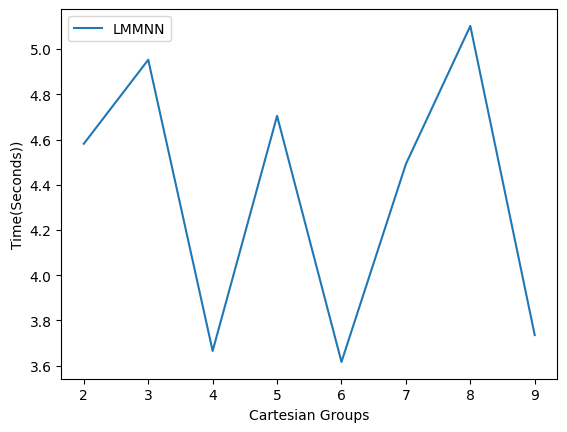

In [69]:
plt.plot(range(2,len(time_took)+2),time_took, label="LMMNN")
plt.xlabel("Cartesian Groups")
plt.ylabel("Time(Seconds))")
plt.legend()
plt.show()

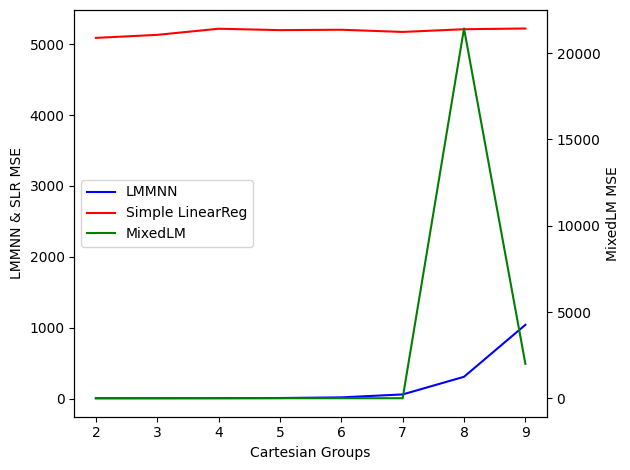

In [58]:
fig, ax1 = plt.subplots()

# Plot the first two plots on the primary y-axis
ax1.plot(ls, errors_lmmnn, 'b', label = "LMMNN")
ax1.plot(ls, errors_lr,'r', label="Simple LinearReg")
ax1.set_ylabel('LMMNN & SLR MSE')

# Create a secondary y-axis for the third plot
ax2 = ax1.twinx()
ax2.plot(ls, errors_mlm,'g', label="MixedLM")
ax2.set_ylabel('MixedLM MSE')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
ax1.set_xlabel("Cartesian Groups")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left')

# Display the plot
plt.tight_layout()
plt.show()

In [40]:
def run_all(g_cols):

    df = df_original.copy()
    # g_cols = ['g1','g2','g3', 'g4', 'g5', 'g6','g7']
    col_to_select = list(col for col in df_original.columns if col.startswith('f') or col.startswith('y')) + g_cols
    df = df_original[col_to_select].copy()
    df['g_cart'] = df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
    df["g_cart"] = pd.factorize(df['g_cart'])[0]
    df.drop(g_cols, axis=1, inplace=True)

    if len(g_cols) == 1:
        df.drop(g_cols, axis=1, inplace=True)

#     print(df.head())

    df.rename(columns={'g_cart': 'z0'}, inplace=True)
    df.rename(columns={f'{col}': f'z{i+1}' for i, col in enumerate(g_cols)}, inplace=True)
#     print(df.head())

    z_cols = sorted([col for col in df.columns if col.startswith('z')], key=lambda x: int(x[1:]))

    # mode = 'slopes'
    mode = 'intercepts'
    n_cats = [len(df[i].unique()) for i in z_cols]
    qs = n_cats
    batch_size = 100
    epochs = 500
    patience = 10
    n_sig2bs = 1
    n_sig2bs_spatial = 0
    est_cors = []
    n_neurons = [50,25,12,6]
    activation = 'linear'
    dropout = []
    spatial_embedded_neurons = []
    dist_matrix = None
    q_spatial = None

    print('n_uniques: ', n_cats)

    X, y = df.drop('y', axis=1), df['y']
    x_cols = [col for col in X.columns if col if not col.startswith('z')]#['z0','z1','z2','z3']]
#     cols_to_scale = [col for col in X.columns if col not in ['z0','z1','z2','z3','t']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train[x_cols] = scaler.fit_transform(X_train[x_cols])
    X_test[x_cols]  = scaler.transform(X_test[x_cols])

    reg = LinearRegression(fit_intercept=True)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    mse_lr = mse(y_test,pred)

#     print(X_train.head())

    def reg_nn(X_train, X_test, y_train, y_test, n_cats, batch=batch_size, epochs=epochs, patience=patience, reg_type='lmm', verbose=False):

        start = time.time()
        if reg_type == 'lmm':
            model_fitted, history, y_pred, sigmas, _, _, n_epochs = reg_nn_lmm(X_train, X_test, y_train, y_test, n_cats, q_spatial, x_cols, batch, epochs, patience,
                                                     n_neurons, dropout, activation,
                                                     mode=mode, n_sig2bs=n_sig2bs, n_sig2bs_spatial=n_sig2bs_spatial,
                                                     est_cors=est_cors, dist_matrix=dist_matrix,
                                                     spatial_embed_neurons=spatial_embedded_neurons, verbose=verbose, log_params=False)
        else:
            raise ValueError(reg_type + 'is an unknown reg_type')
        end = time.time()
        gc.collect()
        K.clear_session()
        mse = np.mean((y_pred - y_test)**2)
#         sns.scatterplot(x=y_test, y=y_pred)
#         plt.xlabel("y_true")
#         plt.ylabel("Predictions")
#         plt.title("LMMNN")
#         plt.show()

        return mse, sigmas, n_epochs, end - start, y_pred

    mse_lmm, sigmas, n_epochs_lmm, time_lmm,y_pred= reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='lmm', verbose=False)
    print(' finished lmm, mse: %.4f' % (mse_lmm))
#     print(' finished lmm, MAE: ',(mae(y_test, y_pred)))

    return mse_lmm, mse_lr, time_lmm

### Mixedlm

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse

In [8]:
def run_mixedlm(g_cols):

    df = df_original.copy()
    # g_cols = ['g1','g2','g3']
    col_to_select = list(col for col in df_original.columns if col.startswith('f') or col.startswith('y')) + g_cols
    df = df_original[col_to_select].copy()
    df['g_cart'] = df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
    df["g_cart"] = pd.factorize(df['g_cart'])[0]
    # df.drop(g_cols, axis=1, inplace=True)

    from sklearn.model_selection import train_test_split
    # X, y = df.drop('target', axis=1), df['target']
    X, y = df.drop('y', axis=1), df['y']

    # cols_to_scale = [col for col in X.columns if col not in ['g1','g2','g_cart']]
    x_cols = [col for col in X.columns if col if not col.startswith('g')]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    scaler = StandardScaler()
    X_train[x_cols] = scaler.fit_transform(X_train[x_cols]) #.values.reshape(-1,1))
    X_test[x_cols]  = scaler.transform(X_test[x_cols]) #.values.reshape(-1,1))

    data_train = pd.concat([X_train, y_train], axis=1)


    groups_combined = "*".join(g_cols)
    formula = f"y ~ f0 + f1 + (0 | {groups_combined})"
    md = sm.MixedLM.from_formula(formula,data_train,groups = data_train['g_cart'])
    mdf = md.fit()
    # print(mdf.summary())
    # print("MSE-train: ", mse(data_train.y, mdf.fittedvalues))
    mlm_pred = mdf.predict(X_test)
    # print("MSE-test: ", mse(y_test, mlm_pred))

    return mse(y_test, mlm_pred)